In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.special import factorial
import sympy as sp
import scipy as sc
from scipy.optimize import minimize_scalar

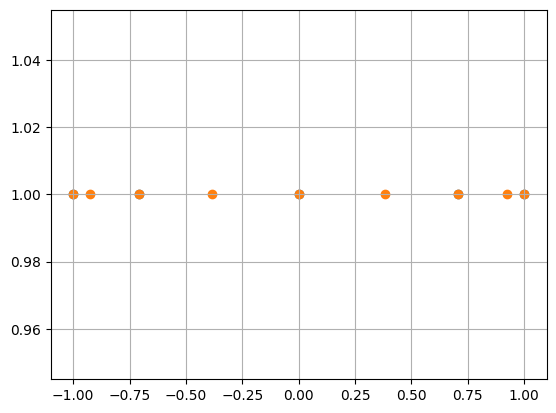

In [2]:

def nodess(k):

    # Extended Chebyshev nodes
    nodes = - np.cos(np.pi  * (2*np.arange(k+1) + 1 ) / (2*k + 2)) / np.cos(np.pi / (2*k + 2))

    # Augmented Chebyshev nodes
    nodes = np.cos((2 * np.arange(2, k + 2) - 3)*np.pi / (2 * (k)))

    # Chebyshev nodes
    nodes = np.cos(np.pi * (2*np.arange(1, k+2) - 1 ) / (2*(k + 1)))

    # Chebyshev nodes second kind
    nodes = np.cos(np.pi * (np.arange(1, k+2) - 1 ) / (k))
    plt.scatter(nodes, np.ones(len(nodes)))

t = np.linspace(-1, 1, 1000)
for k in [4, 8]:
    nodess(k)
plt.grid()
plt.show()

In [34]:
class Performative_Regression:

    def __init__(self, k, n , T, sigma=1, M=1):
        """
        Parameters:
        - k (int): Polynomial degree.
        - n (int): Number of samples for each theta_i.
        - T (float): Total number of rounds, should be > kn.
        - sigma (float, optional): Standard deviation of the noise. Default is 1.
        - M (float, optional): Bound of the derivatives of f. Default is 1.
        """
        self.k = k
        self.n = n
        self.T = T
        self.sigma = sigma
        self.M = M
        self.z = 1.96

        # Produce k+1 Chebyshev nodes
        self.thetas = np.cos(np.pi * (2*np.arange(1, self.k+2) - 1 ) / (2*(self.k + 1)))

        # 
        #self.thetas = np.cos(np.pi * (2*np.arange(self.k+1) + 1 ) / (2*self.k + 2)) / np.cos(np.pi / (2*self.k + 2))


        self.f_hat_values = self.f_hat()
               
    def f(self, theta):
        """
        Computes the true function value at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The function value at the specified theta.
        """

        
        fun = theta + theta**2 
        return fun
  
    def f_hat(self):
        """
        Generates the array of noisy function values at the Chebyshev nodes.

        Returns:
        - numpy.ndarray: Array with element i equal to f_hat(theta_i) where theta_i is the ith Chebyshev node.
        """
        
        Y = (
            np.repeat(self.f(self.thetas)[:, np.newaxis], self.n, axis=1) +
            np.random.normal(0, self.sigma, (self.k+1, self.n))
        )

        f_hat = np.mean(Y, axis=1)

        return f_hat

    def vandermonde_matrix(self):
        """
        Computes the Vandermonde matrix with Chebyshev nodes.

        Returns:
        - numpy.ndarray: The Vandermonde matrix.
        """

        return np.vander(self.thetas, increasing=True)

    def vandermonde_determinant(self):
        """
        Computes the determinant of the Vandermonde matrix.

        Returns:
        - float: The determinant of the Vandermonde matrix.
        """

        det = (-1)**((self.k+1) * self.k / 2 ) * ((self.k+1)**(self.k+1) / 2**(self.k*self.k))**(1/2)
        
        return det   
    
    def true_loss(self, theta):
        """
        Computes the true objective function at a given Chebyshev node.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The true objective function evaluated at theta.
        """

        return self.f(theta)**2 - 2 * theta * self.f(theta) + theta**2
    
    def g_hat(self, theta):
        """
        Computes the estimated g_hat at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated function value at the specified theta.
        """
        p_theta = 0
        for i in range(self.k+1):
            prod = 1
            for j in range(self.k+1):
                if j != i:
                    prod = prod * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            p_theta = p_theta + prod * self.f_hat_values[i]
        
        return p_theta

    def estimated_loss(self, theta):
        """
        Computes the estimated objective function value at a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The estimated objective function value at the specified theta.
        """

        g_estimate = self.g_hat(theta)

        return g_estimate**2 - 2 * theta * g_estimate + theta**2

    def optimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.min(g_values**2 - 2 * theta * g_values + theta**2, axis=0)
    
    def pessimistic_loss(self, theta):

        ci = self.conf_interval_at_theta(theta)

        g_values = np.linspace(self.g_hat(theta) - ci, self.g_hat(theta) + ci, 1000)

        return np.max(g_values**2 - 2 * theta * g_values + theta**2, axis=0)

    def remainder(self, theta):
        """
        Computes the upper bound of the absolute value of the remainder term for a given theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The upper bound of the absolute value of the remainder term at the specified theta.
        """

        cheb_polynomial = np.cos((self.k+1)*np.arccos(theta))/(2**(self.k))

        return self.M * np.abs(cheb_polynomial) / math.factorial(self.k + 1)

    def lagrange_bound(self, theta):
        """
        Computes the sum of the absolute value of the Lagrange polynomials.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The sum of the absolute value of the Lagrange polynomials.
        """

        sum_new = 0
        for i in range(self.k+1):
            sum_new += np.abs(
                (-1)**i * np.sin(np.pi * (2*i + 1) / (2*self.k + 2)) * np.cos((self.k+1)*np.arccos(theta)) / (self.k+1) / (theta - np.cos(np.pi * (2*i + 1) / (2*self.k + 2)))
            )  

        #return np.sqrt(2 - 1 / (self.k + 1))
        return sum_new
       
    def conf_interval_at_theta(self, theta):

        """
        Computes the confidence interval at a theta.

        Parameters:
        - theta (float): A number between -1 and 1.

        Returns:
        - float: The confidence interval at the specified theta.
        """
        B_1 = self.remainder(theta)
        B_2 = self.lagrange_bound(theta) * self.z * self.sigma / np.sqrt(self.n)
        
        return B_1 + B_2

    def bayes_ci(self, theta):
        lagrange_squared_sum = 0

        for i in range(self.k+1):

            lagrange_square = 1
            for j in range(self.k+1):
                if j != i:
                    lagrange_square = lagrange_square * (theta - self.thetas[j]) / (self.thetas[i] - self.thetas[j])

            lagrange_squared_sum += lagrange_square**2

        #return lagrange_squared_sum
        #return self.z * self.sigma * np.sqrt(2 - 1 / (self.k + 1)) / np.sqrt(self.n)
        return self.z * self.sigma * np.sqrt(lagrange_squared_sum) / np.sqrt(self.n)

    def R(self, theta):

        prod = 1 
        for i in range(self.k+1):
            prod = prod * (theta - self.thetas[i])

        #return prod
        #return self.M / 2**self.k / math.factorial(self.k+1)
        return np.abs(prod * self.M / math.factorial(self.k+1))
    
    def minimum(self):

        t = np.linspace(-1, 1, 10000)
        gs = self.estimated_loss(t)
        fs = self.true_loss(t)
        estimated_min = t[np.argmin(gs)]
        true_min = t[np.argmin(fs)]
        return estimated_min, true_min

    def plot_f_vs_g(self):
        
        t = np.linspace(-1, 1, 1000)
        
        plt.plot(t, self.f(t), 'r--', label=r'$f(\theta)$')
        plt.plot(t, self.g_hat(t), 'g--', label=r"$\hat{g}(\theta)$")
        
        #plt.plot(t, self.g_hat(t) - self.R(t) - self.bayes_ci(t), 'k--')
        #plt.plot(t, self.g_hat(t) + self.R(t) + self.bayes_ci(t), 'k--', label="Confidence interval")
        plt.fill_between(t, self.g_hat(t) - self.R(t) - self.bayes_ci(t), self.g_hat(t) + self.R(t) + self.bayes_ci(t), alpha=0.3)
        
    def plot_objectives(self):
        
        t = np.linspace(-1, 1, 1000)
        plt.plot(t, self.true_loss(t), 'C1', label='true objective')
        plt.plot(t, self.estimated_loss(t), 'C1--', label=f'estimated loss for k={self.k}')
        plt.fill_between(t,
                         self.optimistic_loss(t),
                         self.pessimistic_loss(t),
                         alpha=0.3,
                         color='C1')

        estimated_min = self.minimum()[0]
        true_min = self.minimum()[1]
        plt.scatter(true_min, self.true_loss(true_min), label=r'$\theta_{PO}$', color='k')
        plt.scatter(estimated_min, self.true_loss(estimated_min), label=r'$\hat{\theta}_{PO}$', marker='x', color='r')
        plt.xlabel(r"$\theta$")


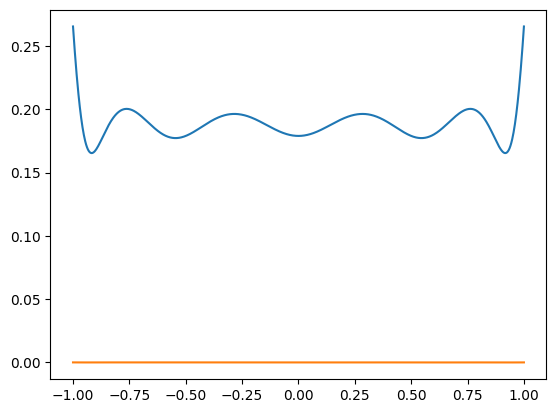

In [35]:
pr = Performative_Regression(k=5, n=1, T=1, sigma=0.1, M=np.sqrt(2))
t = np.linspace(-1, 1, 1000)

plt.plot(t, pr.bayes_ci(t) + pr.R(t))
plt.plot(t, pr.R(t))
plt.show()

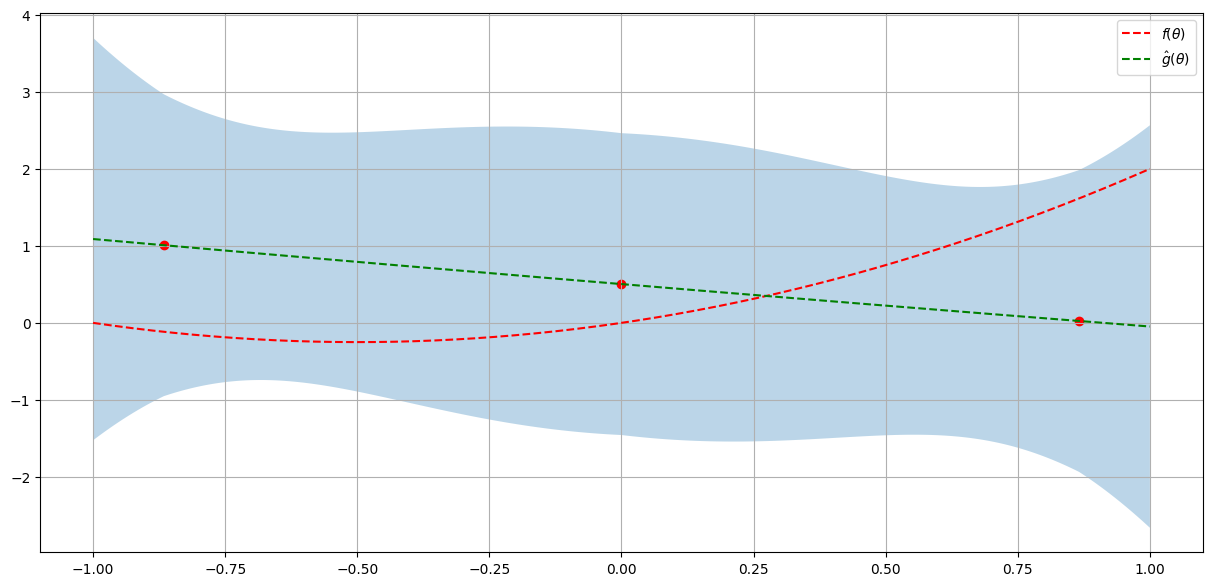

In [36]:
pr = Performative_Regression(k=2, n=1, T=0.1, sigma=1, M=np.sqrt(4))
plt.figure(figsize=(15, 7))
pr.plot_f_vs_g()
#pr.plot_objectives()
for i in pr.thetas:
    plt.scatter(i, pr.g_hat(i), color='r')    
plt.grid()
plt.legend()
plt.show()

In [37]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np

class GaussianRegressionWithPolynomialKernel:
    def __init__(self, degree=2, alpha=0.0, noise_level=1.0):
        """
        Initialize the GaussianRegressionWithPolynomialKernel.

        :param degree: Degree of the polynomial kernel.
        :param alpha: Regularization parameter (ridge regularization).
        :param noise_level: Represents the variance of the observation noise.
        """
        self.degree = degree
        self.alpha = alpha
        self.noise_level = noise_level
        self.model = None

    def fit(self, X, y):
        """
        Fit the Gaussian regression model to the training data.

        :param X: Input data (n_samples, n_features).
        :param y: Target values (n_samples).
        """
        # Adjusting alpha to include noise level
        effective_alpha = self.alpha + self.noise_level
        self.model = KernelRidge(kernel='poly', degree=self.degree, alpha=effective_alpha)
        self.model.fit(X, y)

    def predict(self, X):
        """
        Predict the values for input data.

        :param X: Input data (n_samples, n_features).
        :return: Predicted values (n_samples).
        """
        if self.model is None:
            raise Exception("Model has not been trained yet. Please call the fit method first.")
        return self.model.predict(X)


pr = Performative_Regression(k=2, n=1, T=1, sigma=0.1, M=np.sqrt(4))

pr.thetas


array([ 8.66025404e-01,  6.12323400e-17, -8.66025404e-01])

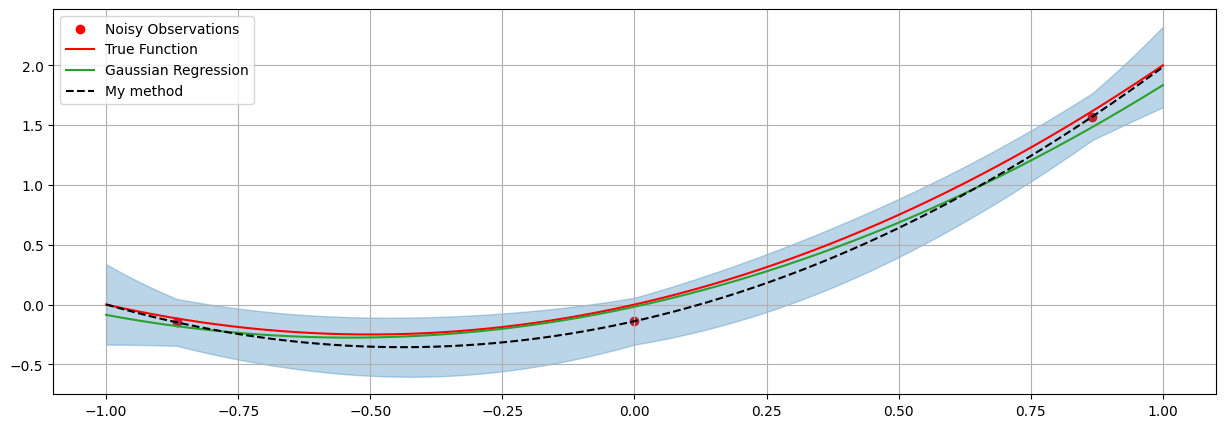

In [38]:
# Generate synthetic data

y_true = pr.f(pr.thetas)  

# Create an instance of the GaussianRegressionWithPolynomialKernel class
gaussian_regression = GaussianRegressionWithPolynomialKernel(degree=pr.k, alpha=0.0, noise_level=0.1)

# Fit the model to the data
gaussian_regression.fit(pr.thetas.reshape(-1, 1), pr.f_hat_values)

# Predict values
X_test = np.linspace(-1, 1, 1000)
y_pred = gaussian_regression.predict(X_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(15, 5))
plt.scatter(pr.thetas, pr.f_hat_values, label="Noisy Observations", color='r')
plt.plot(X_test, pr.f(X_test), 'r', label="True Function")
plt.plot(X_test, y_pred, 'C2', label="Gaussian Regression")
plt.plot(X_test, pr.g_hat(X_test), 'k--', label='My method')
plt.fill_between(X_test, pr.g_hat(X_test) - pr.R(X_test) - pr.bayes_ci(X_test), 
                 pr.g_hat(X_test) + pr.R(X_test) + pr.bayes_ci(X_test), alpha=0.3, color='C0')

#plt.fill_between(X_test, y_pred - 1.96 * y_std, 
#                 y_pred + 1.96 * y_std, alpha=0.3, color='C2')
plt.legend()
plt.grid()
plt.show()


In [7]:
class Adaptive_Interpolation:

    def __init__(self, K, M=1, sigma=0.1):
        """
        K - even
        """
        self.sigma = sigma
        self.M = M
        self.K = K

        # Initialize possible nodes (Chebyshev K+1)
        self.all_nodes = np.cos(np.pi * (2*np.arange(1, self.K+2) - 1 ) / (2*(self.K + 1)))

        self.used_nodes = {node : 0 for node in self.all_nodes}

        self.f_estimates = {self.all_nodes[(self.K + 1) // 2] : self.observation(self.all_nodes[(self.K + 1) // 2])}

    def f(self, theta):

        fun = np.cos(theta) - np.sin(theta)
        
        return fun
    
    def observation(self, node):

        return np.random.normal(self.f(node), self.sigma)

    def g_estimate(self, theta, nodes, estimates_at_nodes):

        sum = 0
    
        for i in range(len(nodes)):
            
            l_i = 1
            for j in range(len(nodes)):
                if j != i:
                    l_i = l_i * (theta - nodes[j]) / (nodes[i] - nodes[j])

            sum += estimates_at_nodes[i] * l_i

        return sum

    def lower_bound(self, theta, nodes, estimates_at_nodes):
        



    def step(self):

        new_node = 1

        # Estimate g(x) using the estimate of f at the nodes
        
        # Compute lower bound of (g_hat(x) - x)^2

        # Take new_node = argmin(LB((g_hat(x) - x)^2))

        # Update the nodes by adding the new node (unless new_node is already in nodes)

    


IndentationError: expected an indented block after function definition on line 43 (757947123.py, line 48)

In [ ]:
ai.g_estimate(t, nodes, ai.observation(nodes))

1.0584171694957296

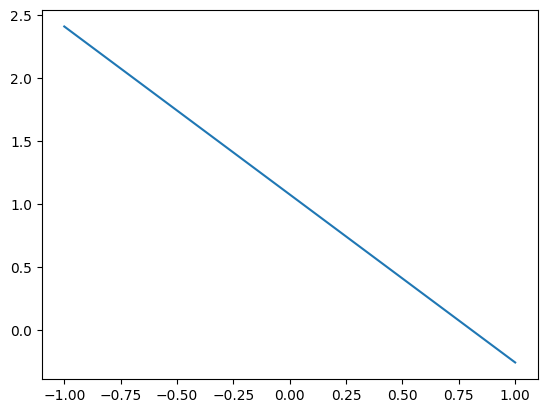

In [ ]:
ai = Adaptive_Interpolation(K=10)


t = np.linspace(-1, 1, 1000)
nodes = np.array([0, 0.5])
observed = ai.observation(nodes)

y = [ai.g_estimate(i, nodes, observed) for i in t]


plt.plot(t, y)
plt.show()

In [ ]:

class PolynomialKernel:
    def __init__(self, degree=2, coef0=1):
        """
        Initialize the polynomial kernel.

        Args:
          degree: The degree of the polynomial kernel (default is 2).
          coef0: The independent term in the kernel function (default is 1).
        """
        self.degree = degree
        self.coef0 = coef0

    def __call__(self, x, y, theta=None):
        """
        Given an input array x of size n and another input array y of 
        size m, compute the n by m kernel matrix whose (i, j)-th entry 
        is k(x_i, y_j).

        Args:
          x: (n,)
          y: (m,)
          theta: Ignored for polynomial kernel.
    
        Returns:
          k_mat: (n, m)
        """
        k_mat = pairwise_kernels(np.atleast_2d(x), np.atleast_2d(y), metric='polynomial', degree=self.degree, coef0=self.coef0)
        return k_mat

class GP:
    def __init__(self, kernel):
        """
        Args:
          kernel: An instance of a kernel class (e.g., PolynomialKernel).
        """
        self.k = kernel

    def predict(
            self,
            x_star,
            X: np.array = None,
            y: np.array = None,
            size: int = 1,
            theta: list = None,
            sigma: float = 0.,
    ):
        # 1. compute kernel matrices
        k_xs_x = self.k(x_star, X)  # m x n*
        k_x_xs = np.transpose(k_xs_x)  # n* x m
        k_xs_xs = self.k(x_star, x_star)  # m x m
        k_x_x = self.k(X, X)  # n* x n*
        cov_x_x = k_x_x + sigma**2 * np.eye(len(X))

        # 2. compute posterior means and covariance matrix
        posterior_mean = np.matmul(k_xs_x, np.linalg.solve(cov_x_x, y))
        posterior_var = (k_xs_xs - np.matmul(k_xs_x, np.linalg.solve(cov_x_x, k_x_xs)))

        self.posterior_mean = posterior_mean
        self.posterior_var = posterior_var

        # 3. draw posterior samples using the posterior mean and covariance matrix
        y_star = np.random.multivariate_normal(
            mean=self.posterior_mean,
            cov=self.posterior_var,
            size=size,
        )

        return y_star